In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
df_train = pd.read_csv("data/other/train_sentiment.csv")
df_test = pd.read_csv("data/other/test_sentiment.csv")

In [3]:
df_train.head()

,review,sentiment
0,incoherent irritating weak unbearable soundtra...,0
1,delightful perfect scene wonderful memorable a...,1
2,narrative pathetic viewer nonsensical frustrat...,0
3,nonsensical direction soundtrack flawed soundt...,0
4,ensemble waste amateurish weak awful presents ...,0


In [4]:
train_X, train_y, test_X, test_y = df_train["review"], df_train["sentiment"], df_test["review"], df_test["sentiment"]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2)

#istyo samo ne bara tuka slpit ako av8

In [5]:
def build_vocab(texts, max_vocab_size):
    counter = Counter()

    for sentence in texts:
        counter.update(sentence.split())

    # Special tokens
    vocab = {
        "<PAD>": 0,
        "<OOV>": 1
    }

    for idx, (word, _) in enumerate(
        counter.most_common(max_vocab_size - 2), start=2
    ):
        vocab[word] = idx

    return vocab

    #skrz isto

In [6]:
max_vocab_size = 10000
vocab = build_vocab(train_X.values, max_vocab_size)

In [7]:
def texts_to_sequences(texts, vocab):
    sequences = []

    for sentence in texts:
        seq = [
            vocab.get(word, vocab["<OOV>"])
            for word in sentence.split()
        ]
        sequences.append(seq)

    return sequences #isto e se i dole i voa

In [8]:
train_X = texts_to_sequences(train_X.values, vocab)
val_X   = texts_to_sequences(val_X.values, vocab)
test_X  = texts_to_sequences(test_X.values, vocab)

In [9]:
def pad(sequences, pad_value=0):
    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )

In [10]:
train_X = pad(train_X, pad_value=0)
val_X   = pad(val_X,pad_value=0)
test_X  = pad(test_X, pad_value=0)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_y   = torch.tensor(val_y.values, dtype=torch.float32)
test_y  = torch.tensor(test_y.values, dtype=torch.float32)

In [11]:
class TextCNN(nn.Module): #malku razlicno
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=2)

        self.fc1 = nn.Linear(64, 64) #ima slicno
        self.dropout = nn.Dropout(0.5)  #voa e plus
        self.fc2 = nn.Linear(64, 1) #isto kaa gore go pisime
        """
        ✔ ова НЕ е CNN ни LSTM
✔ ова е classifier / regressor head
        """

    
    def forward(self, x):
        x = self.embedding(x)          
        x = x.permute(0, 2, 1)        

        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.max(x, dim=2).values
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x) #malku smeneto
        return self.fc2(x).squeeze(1)

In [12]:
model = TextCNN(vocab_size=len(vocab), embedding_dim=64)

In [ ]:
"""
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, 128, padding_idx=0      
        )                                                 CNN+LSTM
-----------------------------------------------------------
        self.conv1 = nn.Conv1d(128, 32, kernel_size=4, padding=2)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, padding=2)
        self.pool2 = nn.MaxPool1d(2)                                CNN
------------------------------------------------------------------------------
        self.lstm1 = nn.LSTM(64, 128, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.1)     LSTM
-----------------------------------------------------------------------------------
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)          # (batch, seq, 128)
        x = x.permute(0, 2, 1)         # (batch, 128, seq)           CNN+LSTM
------------------------------------------------------------------------------
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))                       CNN
---------------------------------------------------------------------------
        x = x.permute(0, 2, 1)         # (batch, seq, features)

        x, _ = self.lstm1(x)
        _, (h, _) = self.lstm2(x)                            LSTM
------------------------------------------------------------------------
        return self.fc(h[-1]) #hidden state се користи за класификација    CNN+LSTM
"""

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


#   ---------------------------VAZNO--------------------------------------
#VOA ima 2kolona 1/0 a u av e emotion anger,saddnes,love,fear.... zatoa tamu e crossEntropy a tuka e voa

In [14]:
train_losses = []      #isto BAS SE
val_losses = []

epochs = 3
batch_size = 64

for epoch in range(epochs):

    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0

    for i in range(0, len(train_X), batch_size):
        X_batch = train_X[i:i+batch_size]
        y_batch = train_y[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / (len(train_X) // batch_size)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        X_val = val_X                     #bez devicce samo
        y_val = val_y

        outputs = model(X_val)
        val_loss = criterion(outputs, y_val)
        running_val_loss += val_loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5)
        
        correct = (preds == y_val).sum().item()

    avg_val_loss = running_val_loss
    val_losses.append(avg_val_loss)

    val_acc = correct / len(y_val)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Val loss: {avg_val_loss:.4f} | "
        f"Val acc: {val_acc:.4f}"
    )

Epoch 1/3 | Train loss: 0.1881 | Val loss: 0.0046 | Val acc: 0.9980
Epoch 2/3 | Train loss: 0.0014 | Val loss: 0.0024 | Val acc: 0.9990
Epoch 3/3 | Train loss: 0.0005 | Val loss: 0.0030 | Val acc: 0.9990


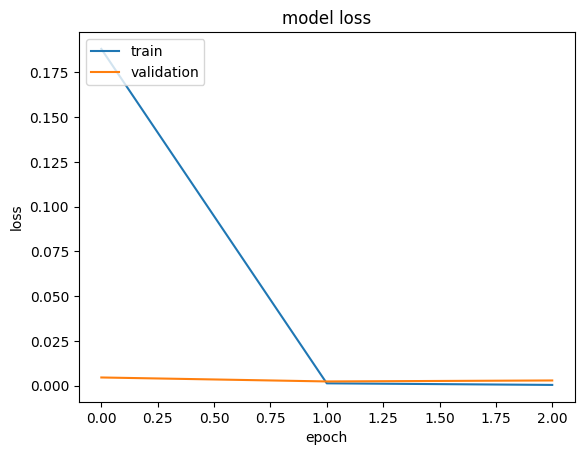

In [15]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# SKROZ ISTO

In [16]:
model.eval()

with torch.no_grad():
    X_test = test_X
    y_test = test_y
    outputs = model(X_test)
    preds = (torch.sigmoid(outputs) >= 0.5)
    test_acc = (preds == y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc:.4f}")
#isto 

Test accuracy: 1.0000


In [17]:
print(classification_report(y_test, preds)) #se  eisto ne pisam vice  samo bez cpy i numpy

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       500
         1.0       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



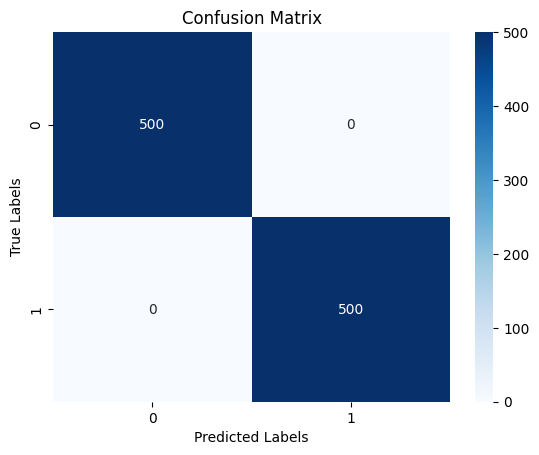

In [18]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#VOA NADOLE NZ OD KAJ E AMA NE  EOD AV8 NITI OD TRANSF

In [19]:
vectorizer = TfidfVectorizer(    #👉 Го претвора текстот во бројки (TF-IDF вектори)
    max_features=5000,         #→ зема само 5000 најважни зборови од целиот корпус
    stop_words="english"       #→ ги брише зборови како: the, is, and, to
)

reviews = pd.concat([df_train["review"], df_test["review"]], axis=0)
sentiments = pd.concat([df_train["sentiment"], df_test["sentiment"]], axis=0)

X_tfidf = vectorizer.fit_transform(reviews)

#voa e TF-IDf

In [20]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_tfidf.toarray())

In [21]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

In [22]:
ari = adjusted_rand_score(sentiments, clusters)
h, c, v = homogeneity_completeness_v_measure(sentiments, clusters)

print(f"ARI: {ari:.4f}")
print(f"Homogeneity: {h:.4f} | Completeness: {c:.4f} | V-measure: {v:.4f}")

#👉 Го оценува квалитетот на кластеризација


ARI: 1.0000
Homogeneity: 1.0000 | Completeness: 1.0000 | V-measure: 1.0000


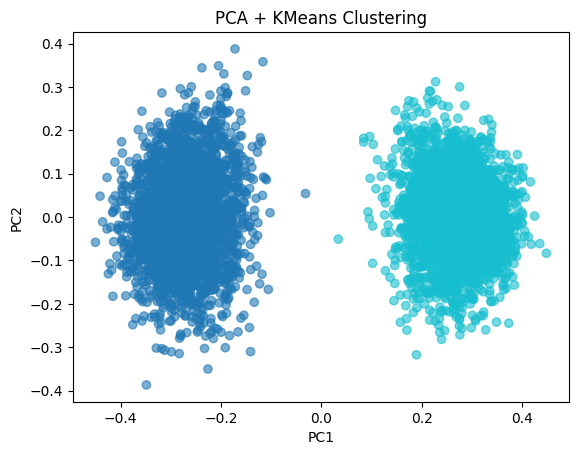

In [23]:
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    cmap="tab10",
    alpha=0.6
)
plt.title("PCA + KMeans Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
